Saving img_style.jpg to img_style (1).jpg
Saving img.jpg to img (2).jpg


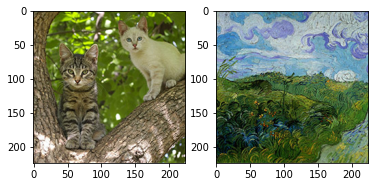

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")
K

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

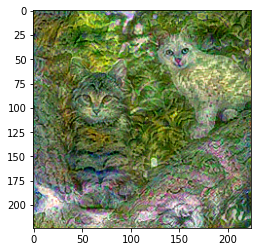

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files #библиотеки для файлов на ноутбуке:
from io import BytesIO
from PIL import Image

import tensorflow as tf
from tensorflow import keras


upl = files.upload()
img = Image.open(BytesIO(upl['img.jpg']))
img_style = Image.open(BytesIO(upl['img_style.jpg']))

plt.subplot(1, 2, 1)
plt.imshow( img )
plt.subplot(1, 2, 2)
plt.imshow( img_style )
plt.show()
#Подготовка изображений для работы в VGG19. ф-ции переводят RGB в BGR со смещением средних значений
x_img = keras.applications.vgg19.preprocess_input( np.expand_dims(img, axis=0) )
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0))
# Вспомогательная ф-ия, которая преобразует из BGR в RGB обратно:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0) #убираем нулевую ось
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of " #действительно ли осей осталось 3?
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # добавляем средние значения к соответствующим цветовым компонентам
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] #меняем местами, чтобы из BGR получить RGB

  x = np.clip(x, 0, 255).astype('uint8') #отбрасываем все, что меньше нуля и больше 255
  return x

vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False 

# Content layer where will pull our feature maps
content_layers = ['block5_conv2']  #определяем вспомогательные коллекции с именами слоев, которые будем потом выделять из сети VGG19

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet') #полносвяз. сеть на конце - false, веса берутся для базы imagenet
vgg.trainable = False #веса не корректируются

style_outputs = [vgg.get_layer(name).output for name in style_layers] #выделяем выходы у VGG19
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs # объединяем выходы

print(vgg.input)
for m in model_outputs:
  print(m) 

model = keras.models.Model(vgg.input, model_outputs) #vgg.input - вход, model_outputs - выходы
for layer in model.layers:
    layer.trainable = False

print(model.summary())      # вывод структуры НС в консоль

def get_feature_representations(model):
  # batch compute content and style features
  style_outputs = model(x_style) #стилевое изображение
  content_outputs = model(x_img) #исходное изображение
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

def get_content_loss(base_content, target): #вычисление потерь по контенту
  return tf.reduce_mean(tf.square(base_content - target)) # base_content - тензор на последнем слое сверточной сети, target - преобразованное изображение
#матрица грама для тензора input_tensor:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1]) #число каналов
  a = tf.reshape(input_tensor, [-1, channels]) #reshape преобразует тензор в матрицу
  n = tf.shape(a)[0] #берем первую размерность от матрицы а
  gram = tf.matmul(a, a, transpose_a=True) #матричное произведение а транспонированная умножить на а
  return gram / tf.cast(n, tf.float32) #делим на n, чтобы усреднить все вычисления, которые делали
#ф-ия вычисляет стиль для строго определенного слоя нейронной сети:
def get_style_loss(base_style, gram_target): #base_style - карта стиля формируемого изображения, gram_target - матрица Грама для соответствующего слоя стилевого изображения
  gram_style = gram_matrix(base_style) # матрица Грама для формируемого изображения
  
  return tf.reduce_mean(tf.square(gram_style - gram_target)) #возвращается среднее арифметическое от квадрата рассогласования матриц
#Общая ф-ия, которая вычисляет все потери:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

num_iterations=100
content_weight=1e3
style_weight=1e-2

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

for i in range(num_iterations):
    with tf.GradientTape() as tape: 
       all_loss = compute_loss(**cfg)
    
    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image)

    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

      # Use the .numpy() method to get the concrete numpy array
      plot_img = deprocess_img(init_image.numpy())
      imgs.append(plot_img)
      print('Iteration: {}'.format(i))

plt.imshow(best_img)
print(best_loss)

image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save("result.jpg")
files.download("result.jpg")